<h1><center>Potential Talents Project</center></h1>

***
## <font color=blue>Description:</font>

This project aims to find talented individuals for the purpose of sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search of. Third, where to find talented individuals is another challenge.
The main goal of this project is to develop a machine learning-powered pipeline that could spot talented individuals, and rank them based on their fitness. This approach could save companies time and finally help them spot potential candidates that could fit the roles they are in search for.
Generally, the sourcing part of candidates is based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role companies are trying to fill in.
After ranking fitting candidates, then employ a review procedure is required, to determine how good a fit they are. Indeed, our machine learning pipeline can re-rank the first list of ranked candidates based on keywords. Then, the list is expected to be re-ranked each time a candidate is starred.

## <font color=blue>Steps:</font>

The goal of this project is to predict how fit the candidate is based on their available information. I want to convey this through four stages:
***
1. **`Explore and analyse the data`**
2. **`Cleaning part`** 
3. **`Modeling part`**

   3.1. **Rank candidates based on a given keyword**
   
   3.2. **Re-rank the list whene some candidates are starred**
***
#### So, let's start.

In [1]:
#import required packages
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import string
from collections import Counter
# Import packages and modules
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec as w2v
from gensim.models import KeyedVectors
import fasttext.util
import csv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim
import os
#nltk.download('punkt')
#nltk.download('stopwords') 
#nltk.download('wordnet')

###  <font color=blue>1. Explore and analyse the dataset</font>

In [2]:
data=pd.read_csv("potential-talents.csv").set_index('id')
data.head()

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [3]:
#drop fit column
data.drop('fit',axis=1,inplace=True)
data.shape

(104, 3)

In [4]:
#count duplicated rows in the total dataset
data.loc[data.duplicated(), :]
print(data.duplicated().sum())

51


In [5]:
#drop duplicated rows in the total dataset
data.drop_duplicates(inplace=True)
data.shape

(53, 3)

In [6]:
#Verify if ther are some null values 
data.isnull().sum()

job_title     0
location      0
connection    0
dtype: int64

* As you can see above, I dropped the 'fit' column which is reserved just for the next results, also removed duplicated rows. Now, we can start applying text preprocessing to our dataset. Mainly, the job_title column, as we are interested more in this step to deal with jobs.

In [7]:
#take a copy of the data
df=data.copy()

* Let's see the uniques values in the job title column

In [8]:
df.job_title.value_counts()

Aspiring Human Resources Professional                                                                                    2
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional                 1
Lead Official at Western Illinois University                                                                             1
Senior Human Resources Business Partner at Heil Environmental                                                            1
Aspiring Human Resources Professional | An energetic and Team-Focused Leader                                             1
HR Manager at Endemol Shine North America                                                                                1
Human Resources professional for the world leader in GIS software                                                        1
RRP Brand Portfolio Executive at JTI (Japan Tobacco International)                                                       1
Information Syst

* As we can dedicate, these texts need some preprocessing, including removing stopwords, uppercases, abbreviations, applying lemmatization, removing digits, and so on. So, it's time to apply the preprocessing to the text.

###  <font color=blue>2. Cleaning the dataset</font>

### Define preprocessing function to clean the text

In [9]:
#define our preprocessing function
def preprocess_text(text):
    all_reviews=list()
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    # Lowercase and lemmatise , pos='v' means verb
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(),pos='v') for token in tokens]
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    x=' '.join(keywords)
    x=' '.join([w for w in x.split() if len(w)>1]) 
    x= re.sub('\w*\d\w*','', x)#remove digits and/or words contain digit
    x= re.sub("türkiye","turkey",x)#this cleans the location column
    x= re.sub("kanada","canada",x)#this cleans the location column
    x= re.sub("amerika birleşik devletleri","united states america",x)#this cleans the location column
    all_reviews.append(x)
    return x

In [10]:
#explore some english stopwords
print('len of stop word in english:',len(stopwords.words('english')))
stopwords.words('english')[:5]

len of stop word in english: 179


['i', 'me', 'my', 'myself', 'we']

In [11]:
#apply preprocessing on the job_title feature
df['job_title'] = df.job_title.apply(preprocess_text)

In [12]:
#replace abreviations by there real texts
df.replace({'job_title' : { 'chro' : 'chief human resources officer', 'svp' : 'senior vice president'
        ,'gphr' : 'global professional in human resources','hris' : 'human resources management system'
        , 'csr' : 'corporate social responsibility', 'sphr' : 'strategic and policy-making certification'
        , 'hr' : 'human resources'}}, regex=True, inplace=True)

In [13]:
#Example after text preprocessing
print(data.iloc[0]['job_title'])
df.iloc[0]['job_title']

2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional


' bauer college business graduate magna cum laude aspire human resources professional'

In [14]:
df.head()

,job_title,location,connection
id,,,
1,bauer college business graduate magna cum lau...,"Houston, Texas",85
2,native english teacher epik english program korea,Kanada,500+
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44
4,people development coordinator ryan,"Denton, Texas",500+
5,advisory board member celal bayar university,"İzmir, Türkiye",500+


* As we can see, the text is pretty cleaned and ready to be used in next steps of modeling. But before, let's see the unique values again and check the text edit.

In [15]:
df.job_title.value_counts()

aspire human resources professional                                                                                                                                                                                                  2
 bauer college business graduate magna cum laude aspire human resources professional                                                                                                                                                 1
lead official western illinois university                                                                                                                                                                                            1
senior human resources business partner heil environmental                                                                                                                                                                           1
aspire human resources professional energetic team focus leader             

* As we can notice, it still some spaces in a few job titles, like the second row ('bauer'), so it would be better if we can apply the second time the preprocessing function. 

In [16]:
#apply preprocessing on the job_title feature
df['job_title'] = df.job_title.apply(preprocess_text)

In [17]:
df.job_title.value_counts()

aspire human resources professional                                                                                                                                                                                         2
bauer college business graduate magna cum laude aspire human resources professional                                                                                                                                         1
lead official western illinois university                                                                                                                                                                                   1
senior human resources business partner heil environmental                                                                                                                                                                  1
aspire human resources professional energetic team focus leader                                                 

* Now, as a last step, let's see the frequency of word's occurrence in our job titles

In [18]:
words_counts = Counter()
for i in df.job_title:
    for word in i.split(" "):
        words_counts[word] += 1

print('There are', len(words_counts) ,'words in the job title column')
words_counts.most_common()

There are 183 words in the job title column


[('human', 39),
 ('resources', 39),
 ('aspire', 13),
 ('professional', 10),
 ('seek', 10),
 ('management', 7),
 ('manager', 7),
 ('university', 6),
 ('student', 6),
 ('business', 5),
 ('generalist', 5),
 ('specialist', 4),
 ('position', 4),
 ('senior', 3),
 ('opportunities', 3),
 ('director', 3),
 ('major', 3),
 ('college', 2),
 ('graduate', 2),
 ('english', 2),
 ('coordinator', 2),
 ('officer', 2),
 ('internship', 2),
 ('retail', 2),
 ('staff', 2),
 ('north', 2),
 ('america', 2),
 ('information', 2),
 ('systems', 2),
 ('leader', 2),
 ('bauer', 1),
 ('magna', 1),
 ('cum', 1),
 ('laude', 1),
 ('native', 1),
 ('teacher', 1),
 ('epik', 1),
 ('program', 1),
 ('korea', 1),
 ('people', 1),
 ('development', 1),
 ('ryan', 1),
 ('advisory', 1),
 ('board', 1),
 ('member', 1),
 ('celal', 1),
 ('bayar', 1),
 ('humber', 1),
 ('system', 1),
 ('chapman', 1),
 ('vice', 1),
 ('president', 1),
 ('chief', 1),
 ('market', 1),
 ('communications', 1),
 ('corporate', 1),
 ('social', 1),
 ('responsibility', 1

We can infer that the most frequent words in the job title column are: **'human', 'resources', 'aspire', 'professional'** and **'seek'**. 

###  <font color=blue>3. Modeling part</font>

     3.1. Rank candidates based on a given keyword
   #### Applying Word Embedding Techniques

In natural language processing (NLP), word embedding is used to represent words mathematically for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word, such that the words that are closer in the vector space are expected to be similar in meaning.
Indeed, the words need to be made meaningful for machine learning or deep learning algorithms. They must be expressed numerically. Algorithms such as TF-IDF, Word2Vec, Doc2vec, Glove, FastText, Transformed models like Bert enable words/sentences to be expressed mathematically as word embedding techniques used to solve such problems.

### 1.  Apply tfidf
***
* TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents.

In [19]:
df_1=df.copy()

In [20]:
def rank_candidates_tfidf(keyword,df,feature_name):
    #store cleaned rows into a list
    corpus=df[feature_name].tolist()
    #apply preprocessing on keyword
    keyword=preprocess_text(keyword)
    #create an instance of tfidfVectorizer
    tfvectoriser = TfidfVectorizer()
    #Append the cleaned keyword to th corpus list 
    corpus.append(keyword)
    #fit the Tfidf vectorizer on the cleaned data
    key_tf=tfvectoriser.fit_transform(corpus)
    #create a dataframe that contains tfidf values of each token for each row in th data
    key_df=pd.DataFrame(key_tf.toarray(), columns=tfvectoriser.get_feature_names())
    shape=key_df.shape
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(key_tf.toarray()[:shape[0]-1], key_tf.toarray()[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_tfidf']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_tfidf',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus.pop()
    return final_df

* Test the rank_candidate function

In [21]:
keyword='aspire human resources'
df_1=rank_candidates_tfidf(keyword,df_1,"job_title")

In [22]:
#number of ranked candidates based on the keyword
print('There are',df_1[df_1['fit_tfidf']!=0].shape[0],'ranked candidates for the job',keyword)

There are 35 ranked candidates for the job aspire human resources


* From the reslut below, we can infer 

In [23]:
#Explore the new column 
df_1.head(10)

,job_title,location,connection,fit_tfidf
id,,,,
97,aspire human resources professional,"Kokomo, Indiana Area",71,0.757836
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.757836
6,aspire human resources specialist,Greater New York City Area,1,0.665663
73,aspire human resources manager seek internship...,"Houston, Texas Area",7,0.601381
27,aspire human resources management student seek...,"Houston, Texas Area",500+,0.428562
72,business management major aspire human resourc...,"Monroe, Louisiana Area",5,0.426162
66,experience retail manager aspire human resourc...,"Austin, Texas Area",57,0.396419
74,human resources professional,Greater Boston Area,16,0.393191
7,student humber college aspire human resources ...,Kanada,61,0.382504


In [24]:
df_1.shape

(53, 4)

### 2- Apply word2vec
***
* Word2vec is another of the frequently used word embedding techniques. The entire corpus is scanned, and the vector creation process is performed by determining which words the target word occurs with more often. In this way, the semantic closeness of the words to each other is also revealed.          
There are two kinds of word2vec: CBOW (continuous bag of words model) and Skipgram (diff is how you train word embedding). We will use then the first type.

In [25]:
#function to get tokens and the word2vec model
def gettokens_word2vec(keyword,df,feature_name):
    #store cleaned rows into a list
    corpus=df[feature_name].tolist()
    #apply preprocessing on keyword
    keyword=preprocess_text(keyword)
    #Append the cleaned keyword to th corpus list 
    corpus.append(keyword)
    #create tokens from our corpus
    corpus_tokens = [word_tokenize(line) for line in corpus]
    #create an instance of word2vec
    w = w2v(corpus_tokens, min_count=3, window=5)# min_count=2 means consider just sentenses with more than 2 words  
    #build vocabs from the corpus
    w.build_vocab(corpus_tokens, progress_per=1000)
    #Get top 10 similar words to 'resources'
    print('Top 10 similar words to the word "resources":',w.wv.most_similar('resources', topn=10))
    return corpus_tokens, w

#define keyword
keyword='aspire human resources'
corpus_tokens, w = gettokens_word2vec(keyword,df_1,'job_title')

Top 10 similar words to the word "resources": [('student', 0.19914475083351135), ('generalist', 0.17272962629795074), ('specialist', 0.17018412053585052), ('seek', 0.1460377722978592), ('manager', 0.06404177844524384), ('position', 0.046536680310964584), ('management', -0.00273532303981483), ('professional', -0.013374545611441135), ('university', -0.016800252720713615), ('director', -0.019639093428850174)]


In [26]:
#function to join tokens with average of each sentense
def sentense_vector(corpus,w):
    line_vec=np.array(0)
    l=list()
    for i in corpus:
        a=0
        for j in i:
            try:
                a=a+1
                line_vec=line_vec+w.wv[j] 
            except:
                line_vec=line_vec
        l.append(line_vec/a)
    return l

In [27]:
corpus_tokens[:2]

[['aspire', 'human', 'resources', 'professional'],
 ['aspire', 'human', 'resources', 'professional']]

In [28]:
#final main function
def rank_candidates_word2vec(df):
    #join tokens with average of each sentense
    all_vec=sentense_vector(corpus_tokens,w)
    #create a dataframe that contains word2vec vectors
    vec_df=pd.DataFrame(all_vec)
    shape=vec_df.shape
    # Explore keys created with theire indexs
    w.wv.key_to_index
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(all_vec[:shape[0]-1], all_vec[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_word2vec']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_word2vec',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus_tokens.pop()
    return final_df

In [29]:
df_1=rank_candidates_word2vec(df_1)

In [30]:
#number of ranked candidates based on the keyword
print('There are',df_1[df_1['fit_word2vec']!=0].shape[0],'ranked candidates for the job',keyword)

There are 53 ranked candidates for the job aspire human resources


* As we can see below, the final result is stored in the fit_word2vec. As we can see, results are not good because word2vec tries to look at words and doesn't take care of the global context. Thus, let's see other techniques that looks also for the context of the word in the sentence.

In [31]:
df_1

,job_title,location,connection,fit_tfidf,fit_word2vec
id,,,,,
104,director administration excellence log,"Katy, Texas",500+,0.000000,0.999920
86,information systems specialist programmer love...,"Gaithersburg, Maryland",4,0.000000,0.999754
80,junior mes engineer information systems,"Myrtle Beach, South Carolina Area",52,0.000000,0.999754
85,rrp brand portfolio executive jti japan tobacc...,Greater Philadelphia Area,500+,0.000000,0.999754
87,bachelor science biology victoria university w...,"Baltimore, Maryland",40,0.000000,0.999653
90,undergraduate research assistant styczynski lab,Greater Atlanta Area,155,0.000000,0.999460
92,seek employment opportunities within customer ...,"Torrance, California",64,0.000000,0.999460
2,native english teacher epik english program korea,Kanada,500+,0.000000,0.999460
93,admissions representative community medical ce...,"Long Beach, California",9,0.000000,0.999264


In [32]:
df_1.shape

(53, 5)

### 3. Glove
***
* Glove stands for the acronym Global Vector. It focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together. It Consider the global property of the data.
***

* First, we should convert the GloVe file containing the word embeddings to the word2vec format for convenience of use. We can do it using the gensim library, a function called glove2word2vec.    

In [33]:
#dowload glove model for the first time
#word2vec_output_file = "glove"+'.word2vec'
#glove2word2vec("glove.6B.100d.txt", word2vec_output_file)

In [34]:
#function to get tokens and the word2vec model
def gettokens_glove2vec(keyword,df,feature_name,glove_path):
    #store cleaned rows into a list
    corpus=df[feature_name].tolist()
    #apply preprocessing on keyword
    keyword=preprocess_text(keyword)
    #Append the cleaned keyword to th corpus list 
    corpus.append(keyword)
    #create tokens from our corpus
    corpus_tokens = [word_tokenize(line) for line in corpus]
    #create an instance of Glove model
    glove2vec_file = glove_path
    model_glove = KeyedVectors.load_word2vec_format(glove2vec_file, binary=False) 
    #get vector of a word
    model_glove.get_vector('king')[:3]
    #Get top 10 similar words to 'resources'
    print('similar words to the word "aspire":',model_glove.similar_by_word('aspire'))
    return corpus_tokens, model_glove

#define keyword
keyword='aspire human resources'
corpus_tokens, glove = gettokens_glove2vec(keyword,df_1,'job_title',"glove.word2vec")

similar words to the word "aspire": [('yearn', 0.645106852054596), ('aspires', 0.6096683144569397), ('aspired', 0.6053599715232849), ('strive', 0.600728452205658), ('pretend', 0.5369201898574829), ('forsake', 0.5339478850364685), ('someday', 0.526309609413147), ('covet', 0.5244596600532532), ('emulate', 0.5235080718994141), ('realise', 0.5204852819442749)]


In [35]:
corpus_tokens[:3]

[['director', 'administration', 'excellence', 'log'],
 ['information',
  'systems',
  'specialist',
  'programmer',
  'love',
  'data',
  'organization'],
 ['junior', 'mes', 'engineer', 'information', 'systems']]

In [36]:
#function to join tokens with average of each sentense
def sentense_vector_glove(corpus,glove):
    line_vec=np.array(0)
    l=list()
    for i in corpus:
        a=0
        for j in i:
            try:
                a=a+1
                line_vec=line_vec+glove.get_vector(j)
            except:
                line_vec=line_vec
        l.append(line_vec/a)
    return l

In [37]:
#final main function
def rank_candidates_glove(df):
    #join tokens with average of each sentense
    all_vec_glove=sentense_vector_glove(corpus_tokens,glove)
    #create a dataframe that contains word2vec vectors
    vec_df_glove=pd.DataFrame(all_vec_glove)
    shape=vec_df_glove.shape
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(all_vec_glove[:shape[0]-1], all_vec_glove[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_glove']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_glove',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus_tokens.pop()
    return final_df

In [38]:
df_1=rank_candidates_glove(df_1)

In [39]:
#number of ranked candidates based on the keyword
print('There are',df_1[df_1['fit_glove']!=0].shape[0],'ranked candidates for the job',keyword)

There are 53 ranked candidates for the job aspire human resources


* Here is the final result. We can see that the fitness with glove is added at the end of the dataframe as fit_glove column.
* Scores seems to be good as we search for aspire human ressources keyword

In [40]:
df_1.head(7)

,job_title,location,connection,fit_tfidf,fit_word2vec,fit_glove
id,,,,,,
97,aspire human resources professional,"Kokomo, Indiana Area",71,0.757836,0.852264,0.999981
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.757836,0.852264,0.999930
6,aspire human resources specialist,Greater New York City Area,1,0.665663,0.896906,0.999838
66,experience retail manager aspire human resourc...,"Austin, Texas Area",57,0.396419,0.949686,0.999734
73,aspire human resources manager seek internship...,"Houston, Texas Area",7,0.601381,0.953348,0.999617
72,business management major aspire human resourc...,"Monroe, Louisiana Area",5,0.426162,0.954558,0.999370
74,human resources professional,Greater Boston Area,16,0.393191,0.958898,0.999257


 * visulyzing words of glove

In [41]:
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [42]:
embeddings_dict['resource'][:6]

array([-0.46946,  1.0245 ,  0.48275, -0.35945,  0.52927, -0.85232],
      dtype=float32)

In [43]:
tsne = TSNE(n_components=2, random_state=0)
tokens = list(embeddings_dict.keys())
vectors = [embeddings_dict[token] for token in tokens]
Y = tsne.fit_transform(vectors[:100])

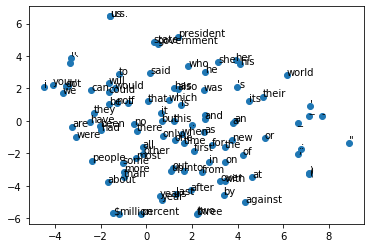

In [44]:
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(tokens, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

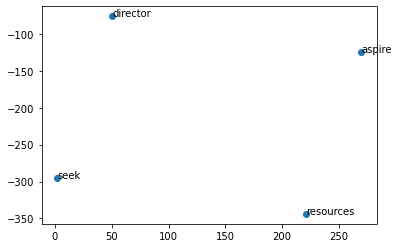

In [45]:
tsne = TSNE(n_components=2, random_state=0)
#choose 4 random words to see there distribution
tokens = ["aspire", "seek", "resources", "director"]
vectors = [embeddings_dict[token] for token in tokens]

Y = tsne.fit_transform(vectors[:100])

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(tokens, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### 4 - Apply Fastext

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English

In [54]:
fast_model = fasttext.load_model('cc.en.300.bin')

In [56]:
fast_model.get_dimension()

300

In [ ]:
fast_model=fasttext.util.reduce_model(fast_model, 100)

In [67]:
fast=KeyedVectors.load_word2vec_format("cc.en.300.vec", binary=False)

In [68]:
df=data.copy()
df['job_title'] = df['job_title'].apply(preprocess_text)
corpus=df['job_title'].tolist()
keyword='aspire human resources'
#corpus.append(keyword)
corpus_tokens = [word_tokenize(line) for line in corpus]

In [ ]:
result = fast.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('Most similar word to King + Woman: ', result)

In [ ]:
#join tokens with average of each sentense
def sentense_vector_fast(corpus):
    line_vec=np.array(0)
    l=list()
    for i in corpus:
        a=0
        for j in i:
            try:
                a=a+1
                line_vec=line_vec+fast.get_vector(j)
            except:
                line_vec=line_vec
        l.append(line_vec/a)
    return l

In [ ]:
all_vec_fast=sentense_vector_fast(corpus_tokens)
vec_df_fast=pd.DataFrame(all_vec_fast)
vec_df_fast.shape

In [78]:
cosine_sim = cosine_similarity(all_vec_fast[:53], all_vec_fast[53].reshape(1, -1))
df['fit_fast']=cosine_sim
final_df=df[df['fit_fast']!=0].sort_values('fit_fast',ascending=False)
final_df.head(10)

#### NB: The result for fastext is not shown above, for the reason that I wasn't be able to load the model with 300 dim on my computer. 

## 5. Apply Bert

* BERT stands for Bidirectional Encoder Representations from Transformers. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of NLP tasks.


In [46]:
#Load the pretrained model 
bert = SentenceTransformer('all-MiniLM-L6-v2')

In [47]:
def rank_candidates_bert(keyword,df,feature_name):
    #load bert model 
    bert = SentenceTransformer('all-MiniLM-L6-v2')
    #store cleaned rows into a list
    corpus=df[feature_name].tolist()
    #apply preprocessing on keyword
    keyword=preprocess_text(keyword)
    #Append the cleaned keyword to th corpus list 
    corpus.append(keyword)
    #encode our sentences
    sentence_embeddings = bert.encode(corpus)
    print("the shape of our encoded sentences is",sentence_embeddings.shape)
    shape=sentence_embeddings.shape
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(sentence_embeddings[:shape[0]-1], sentence_embeddings[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_bert']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_bert',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus.pop()
    return final_df

In [48]:
keyword='aspire human resources'
df_1=rank_candidates_bert(keyword,df_1,"job_title")

the shape of our encoded sentences is (54, 384)


In [49]:
#number of ranked candidates based on the keyword
print('There are',df_1[df_1['fit_bert']!=0].shape[0],'ranked candidates for the job',keyword)

There are 53 ranked candidates for the job aspire human resources


In [50]:
#Explore the new column 
df_1.head(10)

,job_title,location,connection,fit_tfidf,fit_word2vec,fit_glove,fit_bert
id,,,,,,,
97,aspire human resources professional,"Kokomo, Indiana Area",71,0.757836,0.852264,0.999981,0.928787
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.757836,0.852264,0.999930,0.928787
6,aspire human resources specialist,Greater New York City Area,1,0.665663,0.896906,0.999838,0.916763
74,human resources professional,Greater Boston Area,16,0.393191,0.958898,0.999257,0.718712
66,experience retail manager aspire human resourc...,"Austin, Texas Area",57,0.396419,0.949686,0.999734,0.708162
73,aspire human resources manager seek internship...,"Houston, Texas Area",7,0.601381,0.953348,0.999617,0.707531
100,aspire human resources manager graduate may se...,"Cape Girardeau, Missouri",103,0.345520,0.967693,0.998062,0.696832
72,business management major aspire human resourc...,"Monroe, Louisiana Area",5,0.426162,0.954558,0.999370,0.695717
79,liberal arts major aspire human resources analyst,"Baton Rouge, Louisiana Area",7,0.342890,0.964966,0.998315,0.695704


* From the result above, we can see clearly that Bert is the best model till now. And this is not arbitrary, as Bert is pretrained on a large corpus of unlabelled text including the entire Wikipedia(that’s 2,500 million words!) and Book Corpus (800 million words). Indeed, pre-training step is half the magic behind BERT’s success. 

### <font color=purple>End of the part 1 of our project:</font>
     I was able to apply word embeeding thechniques to make the first ranked list. The following step is to rerank this list when a candidate is starred at the top.

### 3.2. Re-rank the list whene some candidates are starred

* As the Bert model was the best, so we will use it for this step.
In this step, we will use the learning to rank (LTR) technique, a machine learning sub-field applicable to a variety of real-world problems that are related to ranking prediction or candidate recommendation. There are 3 main known models: RankNet, LambdaRank and LmabdaMart. In our wase, we will try to use the RankNet model. 

In [51]:
df_1["starred"]=df_1["fit_bert"]

In [52]:
starred_id = [int(item) for item in input("Please, inter ids of candidates you want to star?: ").split()]

Please, inter ids of candidates you want to star?: 73 74 6


In [53]:
for id in starred_id:
    df_1['starred'][id]=1

In [54]:
df_1.head(10)

,job_title,location,connection,fit_tfidf,fit_word2vec,fit_glove,fit_bert,starred
id,,,,,,,,
97,aspire human resources professional,"Kokomo, Indiana Area",71,0.757836,0.852264,0.999981,0.928787,0.928787
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.757836,0.852264,0.999930,0.928787,0.928787
6,aspire human resources specialist,Greater New York City Area,1,0.665663,0.896906,0.999838,0.916763,1.000000
74,human resources professional,Greater Boston Area,16,0.393191,0.958898,0.999257,0.718712,1.000000
66,experience retail manager aspire human resourc...,"Austin, Texas Area",57,0.396419,0.949686,0.999734,0.708162,0.708162
73,aspire human resources manager seek internship...,"Houston, Texas Area",7,0.601381,0.953348,0.999617,0.707531,1.000000
100,aspire human resources manager graduate may se...,"Cape Girardeau, Missouri",103,0.345520,0.967693,0.998062,0.696832,0.696832
72,business management major aspire human resourc...,"Monroe, Louisiana Area",5,0.426162,0.954558,0.999370,0.695717,0.695717
79,liberal arts major aspire human resources analyst,"Baton Rouge, Louisiana Area",7,0.342890,0.964966,0.998315,0.695704,0.695704


In [56]:
# Implement the Ranknet model
class RankNet(nn.Module):
    def __init__(self, inputs=384, outputs=1):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(inputs, 256),
            nn.Dropout(0.5),
            #nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, outputs),
            nn.Sigmoid()
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_1, input_2):
        result_1 = self.model(input_1) 
        result_2 = self.model(input_2) 
        pred = self.sigmoid(result_1 - result_2) #input_1 is more relevant than input_2
        return pred

    def predict(self, input):
        result = self.model(input)
        return result

In [57]:
#GENERATE DATA
rows_1 = df_1.sample(n = 100, replace = True)
rows_2 = df_1.sample(n = 100, replace = True)

In [58]:
#get list of job titles for each data generated
job_list_1 = list(rows_1['job_title'])
job_list_2 = list(rows_2['job_title'])

In [59]:
doc_1 = bert.encode(job_list_1)
doc_2 = bert.encode(job_list_2)
doc_1 = torch.from_numpy(doc_1).float()
doc_2 = torch.from_numpy(doc_2).float()

In [60]:
print('doc_1.shape',doc_1.shape)
print('doc_2.shape',doc_2.shape)

doc_1.shape torch.Size([100, 384])
doc_2.shape torch.Size([100, 384])


In [61]:
#Define Y true labels
y_1_true = list(rows_1['starred'])
y_2_true = list(rows_2['starred'])
y_true = torch.tensor([1.0 if y1_i>y2_i else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y_1_true, y_2_true)]).float()

In [62]:
y_true=y_true.unsqueeze(1)

In [63]:
y_true.shape

torch.Size([100, 1])

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(optimiz, list_lrs, num_epochs):
    
    dict_best=dict()
    dict_hidden=dict()
    loss_best=0
    num_epochs = num_epochs
    model = RankNet().to(device)
    #Loss function and optimizer
    criterion = nn.BCELoss()
    for lr in list_lrs:
        if optimiz == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
        elif optimiz == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        elif optimiz =='Adadelta':
            optimizer = torch.optim.Adadelta(model.parameters(), lr = lr)

        print('lr: ', lr, 'optimizer: ', optimiz)
        base_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
        base_path = os.path.dirname(base_path)
        data_path = base_path + '/train_result.txt'

        total_step = len(y_true)
        for epoch in range(num_epochs):
            pred = model(doc_1, doc_2)
            loss = criterion(pred, y_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch % 100 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
            if loss_best==0:
                loss_best=loss.item()
            if loss.item()<loss_best:
                loss_best=loss.item()
                name_model=optimiz+'model.ckpt'
                torch.save(model.state_dict(), name_model)
        
        dict_hidden[lr]=loss_best    
        print('>' * 60)
    dict_best[optimiz]=dict_hidden
    lr_min=min(dict_hidden, key=dict_hidden.get)
    print("=="*100)
    print('Best model with the optimizer', optimiz,':learning rate =:',lr_min,'; loss =', dict_hidden[lr_min])
    return model, loss

In [65]:
#Test 3 types of optimizers and different learning rates
optimizer_list=['Adam','SGD','Adadelta']
for optimiz in optimizer_list:
    model, loss =train(optimiz=optimiz, list_lrs=[0.2, 0.1, 0.01, 0.001, 0.0001, 0.00001], num_epochs=1000)

lr:  0.2 optimizer:  Adam
Epoch [1/1000], Loss: 0.6934
Epoch [101/1000], Loss: 0.5334
Epoch [201/1000], Loss: 0.6931
Epoch [301/1000], Loss: 0.6893
Epoch [401/1000], Loss: 0.6931
Epoch [501/1000], Loss: 0.6931
Epoch [601/1000], Loss: 0.6893
Epoch [701/1000], Loss: 0.6196
Epoch [801/1000], Loss: 0.6196
Epoch [901/1000], Loss: 0.6210
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
lr:  0.1 optimizer:  Adam
Epoch [1/1000], Loss: 0.6172
Epoch [101/1000], Loss: 0.6348
Epoch [201/1000], Loss: 0.6918
Epoch [301/1000], Loss: 0.6931
Epoch [401/1000], Loss: 0.6780
Epoch [501/1000], Loss: 0.6893
Epoch [601/1000], Loss: 0.6931
Epoch [701/1000], Loss: 0.6880
Epoch [801/1000], Loss: 0.6855
Epoch [901/1000], Loss: 0.6931
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
lr:  0.01 optimizer:  Adam
Epoch [1/1000], Loss: 0.6780
Epoch [101/1000], Loss: 0.7028
Epoch [201/1000], Loss: 0.6742
Epoch [301/1000], Loss: 0.6980
Epoch [401/1000], Loss: 0.6638
Epoch [501/1000], Loss: 0.6014

#### Load the best model which is the model whith SGD otimizer and a learning rate equal to 0.2

In [66]:
#load th ebest model to our device
model = RankNet().to(device)
model.load_state_dict(torch.load('SGDmodel.ckpt'))

<All keys matched successfully>

In [67]:
pred_scores = []
for i in df_1['job_title']:
    sentence_embeddings = bert.encode(i)
    sentence_embeddings_tensor = torch.from_numpy(sentence_embeddings).float()
    pred = round(model.predict(sentence_embeddings_tensor).detach().numpy().sum(),2)
    pred_scores.append(pred)

df_1['rerank_fit'] = pred_scores
df_1.sort_values(by ='rerank_fit', ascending = False).head()

,job_title,location,connection,fit_tfidf,fit_word2vec,fit_glove,fit_bert,starred,rerank_fit
id,,,,,,,,,
97,aspire human resources professional,"Kokomo, Indiana Area",71,0.757836,0.852264,0.999981,0.928787,0.928787,1.0
99,seek human resources position,"Las Vegas, Nevada Area",48,0.272752,0.976729,0.994912,0.661867,0.661867,1.0
4,people development coordinator ryan,"Denton, Texas",500+,0.000000,0.998742,0.949661,0.450898,0.450898,1.0
70,retire army national guard recruiter office ma...,"Virginia Beach, Virginia",82,0.107788,0.991054,0.974650,0.480588,0.480588,1.0
81,senior human resources business partner heil e...,"Chattanooga, Tennessee Area",455,0.141075,0.991187,0.970839,0.528106,0.528106,1.0


* Let's see the total dataframe.

In [68]:
df_1.sort_values(by ='rerank_fit', ascending = False)

,job_title,location,connection,fit_tfidf,fit_word2vec,fit_glove,fit_bert,starred,rerank_fit
id,,,,,,,,,
97,aspire human resources professional,"Kokomo, Indiana Area",71,0.757836,0.852264,0.999981,0.928787,0.928787,1.00
99,seek human resources position,"Las Vegas, Nevada Area",48,0.272752,0.976729,0.994912,0.661867,0.661867,1.00
4,people development coordinator ryan,"Denton, Texas",500+,0.000000,0.998742,0.949661,0.450898,0.450898,1.00
70,retire army national guard recruiter office ma...,"Virginia Beach, Virginia",82,0.107788,0.991054,0.974650,0.480588,0.480588,1.00
81,senior human resources business partner heil e...,"Chattanooga, Tennessee Area",455,0.141075,0.991187,0.970839,0.528106,0.528106,1.00
3,aspire human resources professional,"Raleigh-Durham, North Carolina Area",44,0.757836,0.852264,0.999930,0.928787,0.928787,1.00
67,human resources staff recruit professional,"Jackson, Mississippi Area",500+,0.192671,0.989467,0.988640,0.606238,0.606238,1.00
13,human resources coordinator intercontinental b...,"Atlanta, Georgia",500+,0.148562,0.989463,0.989137,0.613546,0.613546,1.00
76,aspire human resources professional passionate...,"New York, New York",212,0.250602,0.976719,0.996606,0.620164,0.620164,1.00


### Final Result:
As we can see above, the ranked list based on Bert model is being reranked successfully. As we can see, the 3 chosen candidates with id equal to 73, 74, and 6 are rightly labeled as 1. Then, we can say that our model reaches strongly the goal of this project.

***
## <font color=blue>Conclusion:</font>

From the steps that I followed in this project, I can infer that BERT model was the best to find the similarity between our data and the targeted keyword/phrase. As for the second part of Re-Ranking, I run the based model of LTR techniques which is the RankNet model. 
The best model was with the optimizer SGD and a learning rate equal to 0.2. Thus, gives a loss score of 0.44%. 